In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 陝西資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-陝西1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-陝西2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-陝西3.xls')

patent_df = pd.concat([df1,df2,df3],ignore_index=True,sort=True)

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'61\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [5]:
patent_df_firm.shape

(4249, 38)

In [6]:
firm_gd.shape

(3874, 6)

In [7]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [8]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\陝西_廠商.xlsx')

# 非模糊比對

In [9]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(634, 45)
(7489, 45)


In [10]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(3294, 50)
(6074, 50)


D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [11]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\陝西_結果.xlsx')

# merge舊資料

In [4]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(314, 44)
(5132, 44)
(1612, 49)
(5132, 49)


In [5]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\陝西_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', 'CPC', 'IPC', 'inpadoc同族', 'inpadoc同族个数', '专利寿命（月）',
       '专利类型', '中国申请人区县', '中国申请人地市', '优先权信息', '公开国别', '公开（公告）号', '公开（公告）日',
       '发明人', '合享价值度', '同族国家', '失效日', '序号', '引证专利', '引证科技文献', '扩展同族', '扩展同族个数',
       '文献页数', '权利要求数量', '标准化申请人', '标题', '申请人', '申请人国别代码', '申请人地址', '申请人省市代码',
       '申请人类型', '申请号', '申请日', '简单同族', '简单同族个数', '被引证专利', '被引证国别(forward)',
       '被引证次数', '链接到incoPat', 'name', 'address', '完整地址', 'lat', 'lnt', '西安',
       '寶雞', '楊凌農業', '渭南', '榆林', '咸陽', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [6]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','西安','寶雞','楊凌農業','渭南','榆林','咸陽','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(1457, 58)

In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\陝西_結果.xlsx')

# 模糊比對

In [12]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

(707, 45)
(7400, 45)


In [13]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

(3264, 50)
(6011, 50)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\陝西_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\陝西_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\陝西_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(1457, 58)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(5132, 58)
(47, 58)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\陝西_結果.xlsx')

# 作圖

In [7]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [8]:
patent_count.sort_values()

申请人2
57321部队渭沣微电器厂       1
眉县金星农机服务公司          1
眉县钢管家具厂             1
瞿伏川                 1
瞿克桑                 1
                 ... 
陕西科技大学           3735
西北工业大学           3895
西安电子科技大学         3991
长安大学             4327
西安交通大学           6174
Name: 專利數, Length: 25303, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\陝西_結果.xlsx',index_col=0)
target1 = (34.19338,108.89097)
merge_df['西安'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (34.34655,107.23253)
merge_df['寶雞'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (34.27387,108.08182)
merge_df['楊凌農業'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (34.50049,109.42551)
merge_df['渭南'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
target5 = (38.28539,109.73458)
merge_df['榆林'] = merge_df.apply(lambda x:how_far(target5,(x['lat'],x['lnt'])),axis=1)
target6 = (34.3296,108.70899)
merge_df['咸陽'] = merge_df.apply(lambda x:how_far(target6,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [9]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\陝西_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (34.19338,108.89097)
target2 = (34.34655,107.23253)
target3 = (34.27387,108.08182)
target4 = (34.50049,109.42551)
target5 = (38.28539,109.73458)
target6 = (34.3296,108.70899)

for i in merge_df[merge_df['西安']==''].index:
    merge_df.loc[i,'西安'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'寶雞'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'楊凌農業'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'渭南'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'榆林'] = how_far(target5,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'咸陽'] = how_far(target6,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['西安']<10)or(x['寶雞']<10)or(x['楊凌農業']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['渭南']<10)or(x['榆林']<10)or(x['咸陽']<10)) else 0,axis=1)

In [11]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\陝西_結果.xlsx')

In [12]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(5132, 58)
0.612626656274357
0.013834762275915822


In [13]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       3144
1.0        452
2.0        260
3.0        188
4.0        125
5.0         99
6.0         77
7.0         71
8.0         57
9.0         50
10.0        50
11.0        44
12.0        37
13.0        40
14.0        16
15.0        30
16.0        23
17.0        16
18.0        14
19.0        17
20.0        13
21.0         7
22.0        19
23.0        11
24.0         8
25.0         7
26.0         6
27.0         7
28.0        10
29.0        12
30.0         7
31.0         4
32.0         5
33.0         5
34.0         6
35.0         9
36.0         8
37.0         1
38.0         2
39.0         5
40.0         5
41.0         7
42.0         2
43.0         3
44.0         6
45.0         1
46.0         4
47.0         2
48.0         2
49.0         4
50.0         1
51.0         3
52.0         3
53.0         3
54.0         4
55.0         1
56.0         1
57.0         2
58.0         3
59.0         1
60.0         3
61.0         1
62.0         1
63.0         2
64.0         4
66.0         3
67.0  

In [14]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0     33
1.0      5
2.0      2
3.0      1
5.0      1
6.0      2
7.0      1
8.0      1
31.0     1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

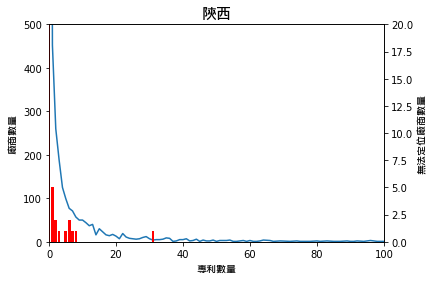

In [15]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('陝西',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,500])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\陝西_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','责任','集团','股份','控股','总公司','分公司','公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

1213
0.24024559318676966
36


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1       307
2       172
3       107
4        75
5        59
6        41
7        43
8        35
9        27
10       27
11       25
12       20
13       22
14       12
15       16
16       15
17       10
18        9
19        8
20        8
21        5
22       14
23        9
24        3
25        4
26        4
27        4
28        5
29        7
30        4
31        1
32        3
33        2
34        4
35        4
36        2
38        1
39        3
40        3
41        4
42        1
43        1
44        3
45        2
46        3
47        1
48        1
51        2
52        3
53        2
54        3
55        1
56        1
57        1
58        2
60        1
61        1
62        2
63        1
64        3
66        1
67        1
72        1
74        1
76        1
80        2
83        1
85        1
87        1
89        2
90        1
91        1
92        1
94        1
96        1
100       1
102       1
116       1
118       1
128       1
129       1
130       2
132       1


In [5]:
not_merge[not_merge['專利數']>=400].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,申请人类型,申请号,申请日,简单同族,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,西安,寶雞,楊凌農業,渭南,榆林,咸陽,早期園區,近期園區,專利數,name_clean
5056,,,,,,,,G06F11/22,CN103913693A; CN103913693B,2,0,发明授权,[碑林],[西安],,CN,CN103913693B,2016-12-28 00:00:00,樊江锋; 周龙; 姚莉娟; 王旭东; 徐连波,7,CN,,4604,CN1221920A; CN1949180A; CN101018165A; CN202110438U; CN102411553A,,...,企业,CN201210593714.9,2012-12-31 00:00:00,CN103913693A; CN103913693B,2,,,0,View in incopat\r\nCN103913693B,中国航空工业集团公司第六三一研究所,中国航空工业集团公司第六三一研究所,陕西省西安市太白北路156号,1,34.1825,108.874,2.001423,152.233391,73.657968,61.828024,461.795966,22.278113,1,0,410,中国航空工业第六三一研究所
4959,,,,,,,,B62D21/02; B60G21/055,CN102923193B; CN102923193A,2,48,发明授权,[碑林],[西安],,CN,CN102923193B,2015-09-09 00:00:00,上官望义; 杨志刚; 申伶; 杨银辉; 赵化刚; 冯广华,5,CN,2016-11-22 00:00:00,13524,CN102555722A; CN201694247U; CN201423898Y; US20110148065A1; CN202986728U; CN201023408Y; CN201116068Y; CN201824824U; JP09076716A,,...,企业,CN201210478955.9,2012-11-22 00:00:00,CN102923193A; CN102923193B,2,,,0,View in incopat\r\nCN102923193B,陕西重型汽车有限公司,陕西重型汽车有限公司,陕西省西安市经济技术开发区泾渭工业园陕汽大道1号,1,34.4625,109.005,31.634474,163.430825,87.416890,38.899756,429.229645,30.919753,0,0,494,陕西重型汽车
4946,,,,,,,,F02K1/82; B64D33/04,CN102926888A; CN102926888B,2,0,发明授权,,[西安],,CN,CN102926888B,2014-10-22 00:00:00,方力; 王家启; 艾俊强; 李青,9,CN,,28753,US7784284B2; US3631678A; US5170964A; US7581400B2; US7681400B2; US7753311B2,,...,企业,CN201210466023.2,2012-11-16 00:00:00,CN102926888A; CN102926888B,2,,,0,View in incopat\r\nCN102926888B,中国航空工业集团公司西安飞机设计研究所,中国航空工业集团公司西安飞机设计研究所,陕西省西安市72号信箱,0,34.6598,109.25,61.374602,188.512510,115.558526,23.904704,404.656986,61.738598,0,0,724,中国航空工业西安飞机设计研究所
5047,,,,,,,,H01F27/26; H01F41/00,CN103035376B; CN103035376A,2,,发明授权,[未央],[西安],,CN,CN103035376B,2016-05-11 00:00:00,宓传龙; 韩晓东; 孟丽坤; 马文选; 汪军,9,CN,,8136,CN201392713Y; CN201397727Y; CN201465731U; CN202110919U; CN102436923A,,...,企业,CN201210591601.5,2012-12-29 00:00:00,CN103035376A; CN103035376B,2,,,0,View in incopat\r\nCN103035376B,中国西电电气股份有限公司,中国西电电气股份有限公司,陕西省西安市唐兴路7号,1,34.2327,108.893,4.362786,153.371943,74.830038,57.310827,456.017191,20.043664,1,0,1390,中国西电电气


Text(0.5, 0, '專利數量')

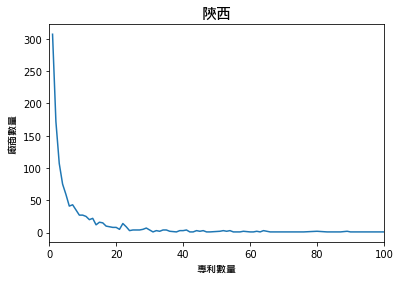

In [6]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('陝西',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [7]:
cleaned.to_excel(r'E:\paper\名稱merge\陝西_結果.xlsx')

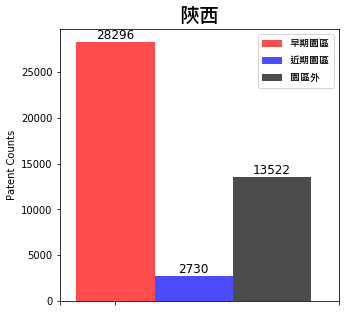

In [10]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('陝西',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)

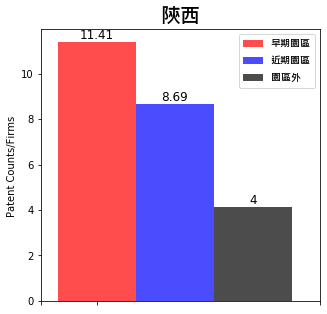

In [11]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('陝西',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)